In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set(style="whitegrid")

# **Loading data and creating Signals objects**

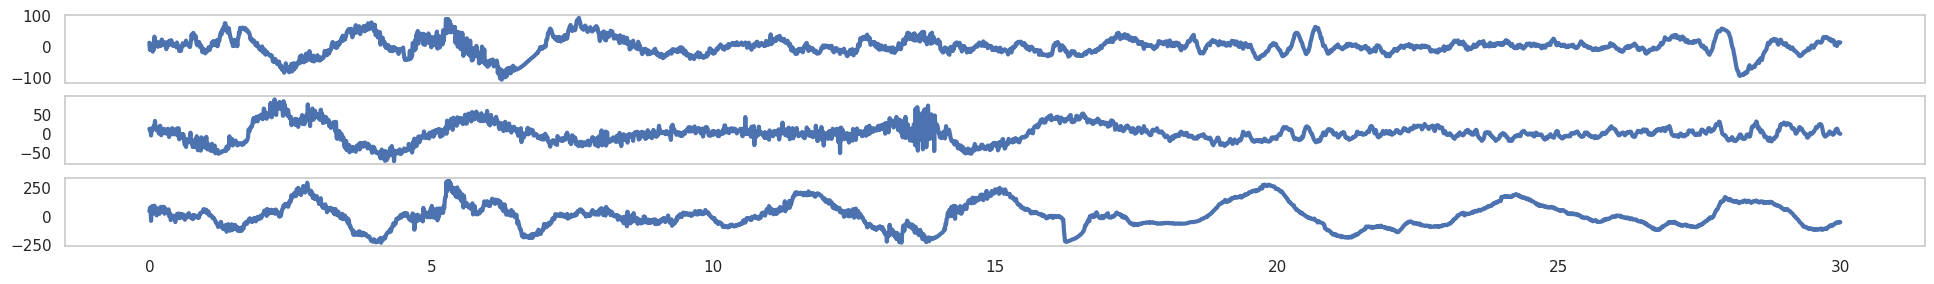

In [10]:
from msr.data.download.sleep_edf import load_sleep_edf_raw_tensors_for_split, FS
from msr.data.measurements import SleepEDFMeasurement

data, targets = load_sleep_edf_raw_tensors_for_split("val")
data, targets = data.numpy(), targets.numpy()
sample = data[111]
eeg_0, eeg_1, eog = sample
measurement = SleepEDFMeasurement(eeg_0, eeg_1, eog, FS)
eeg_sig = measurement['eeg_0']

measurement.plot(0, 30)

{'basic__mean': -0.22604118844119542,
 'basic__std': 27.952594102686135,
 'basic__median': 0.2368742368742295,
 'basic__skewness': -0.3174131216056651,
 'basic__kurtosis': 1.3348795401472051,
 'basic__energy': 2344195.835065196,
 'peaks_troughs__peaks__mean': 4.858247875482337,
 'peaks_troughs__peaks__std': 29.11468257803433,
 'peaks_troughs__peaks__median': 3.932112332112325,
 'peaks_troughs__peaks__skewness': -0.26956457618827684,
 'peaks_troughs__peaks__kurtosis': 1.2164632021168025,
 'peaks_troughs__peaks__energy': 2608574.3382337415,
 'peaks_troughs__troughs__mean': -5.145250207374463,
 'peaks_troughs__troughs__std': 28.030252675739288,
 'peaks_troughs__troughs__median': -3.4583638583638656,
 'peaks_troughs__troughs__skewness': -0.5656061154207935,
 'peaks_troughs__troughs__kurtosis': 1.5175118213261882,
 'peaks_troughs__troughs__energy': 2431632.9822982694,
 'peaks_troughs__amplitudes__mean': 10.0034980828568,
 'peaks_troughs__amplitudes__std': 11.760791765527488,
 'peaks_troughs

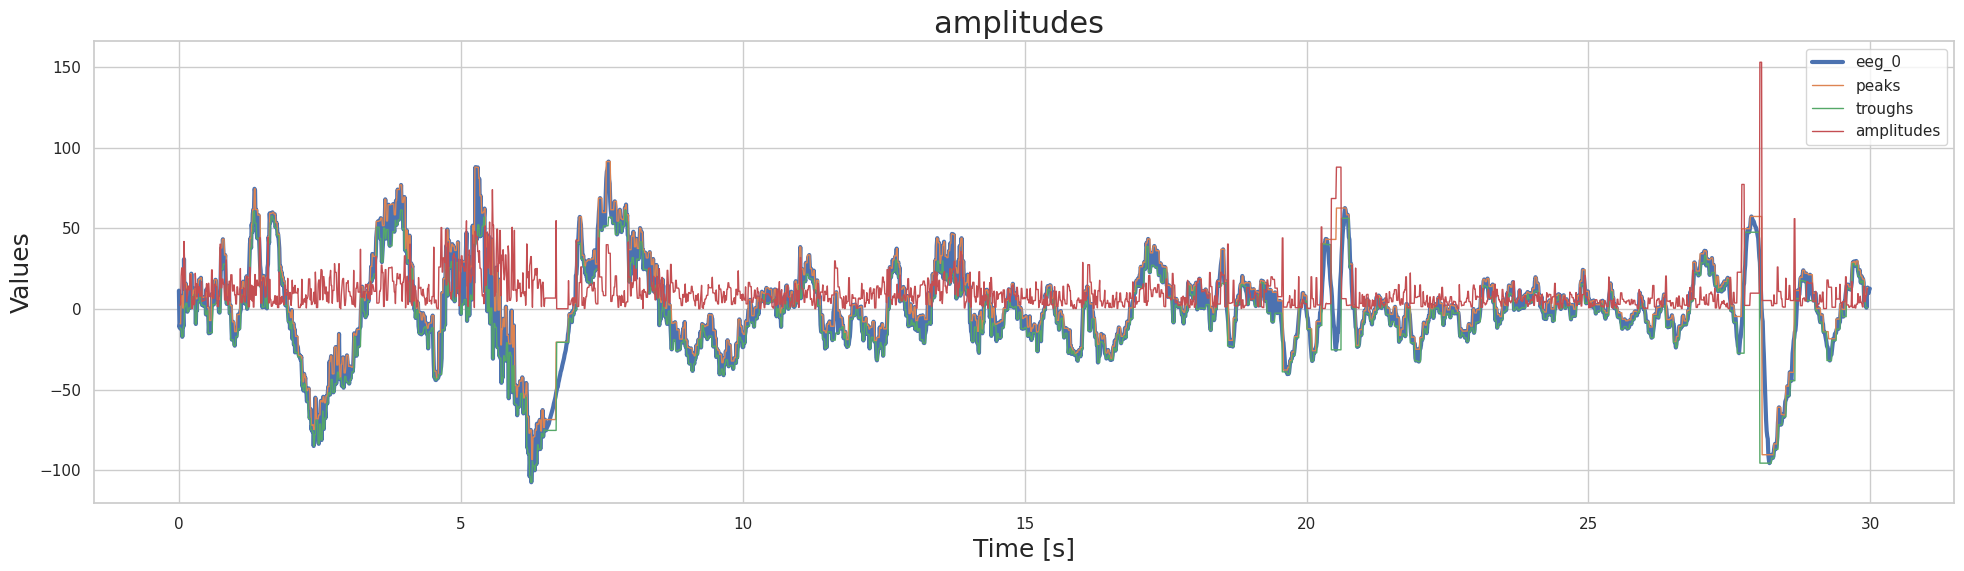

In [15]:
eeg_sig.extract_features(return_arr=False, plot=True)

In [16]:
import numpy as np

In [334]:
import pywt

def plot_dwt(data, wavelet='db5'):
    fig, ax = plt.subplots(figsize=(14,2))
    ax.set_title("Original Chirp Signal: ")
    ax.plot(chirp_signal)
    plt.show()

    fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(14, 10))
    for i in range(5):
        (data, coeff_d) = pywt.dwt(data, wavelet)
        axes[i, 0].plot(data, 'r')
        axes[i, 1].plot(coeff_d, 'g')
        axes[i, 0].set_ylabel("Level {}".format(i + 1), fontsize=14, rotation=90)
        axes[i, 0].set_yticklabels([])
        if i == 0:
            axes[i, 0].set_title("Approximation coefficients", fontsize=14)
            axes[i, 1].set_title("Detail coefficients", fontsize=14)
        axarr[i, 1].set_yticklabels([])
    plt.tight_layout()
    plt.show()

In [339]:
x = np.linspace(0, 1, num=2048)
chirp_signal = np.sin(250 * np.pi * x**2)

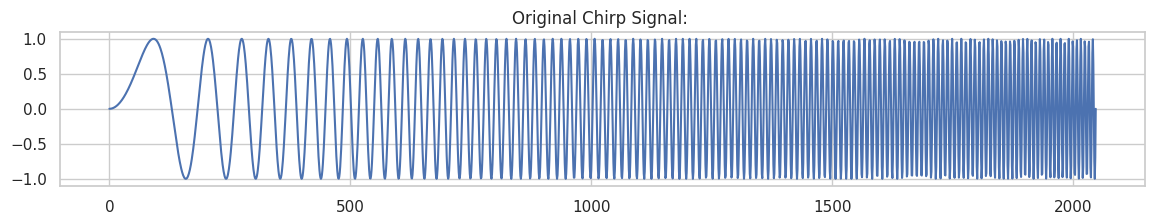

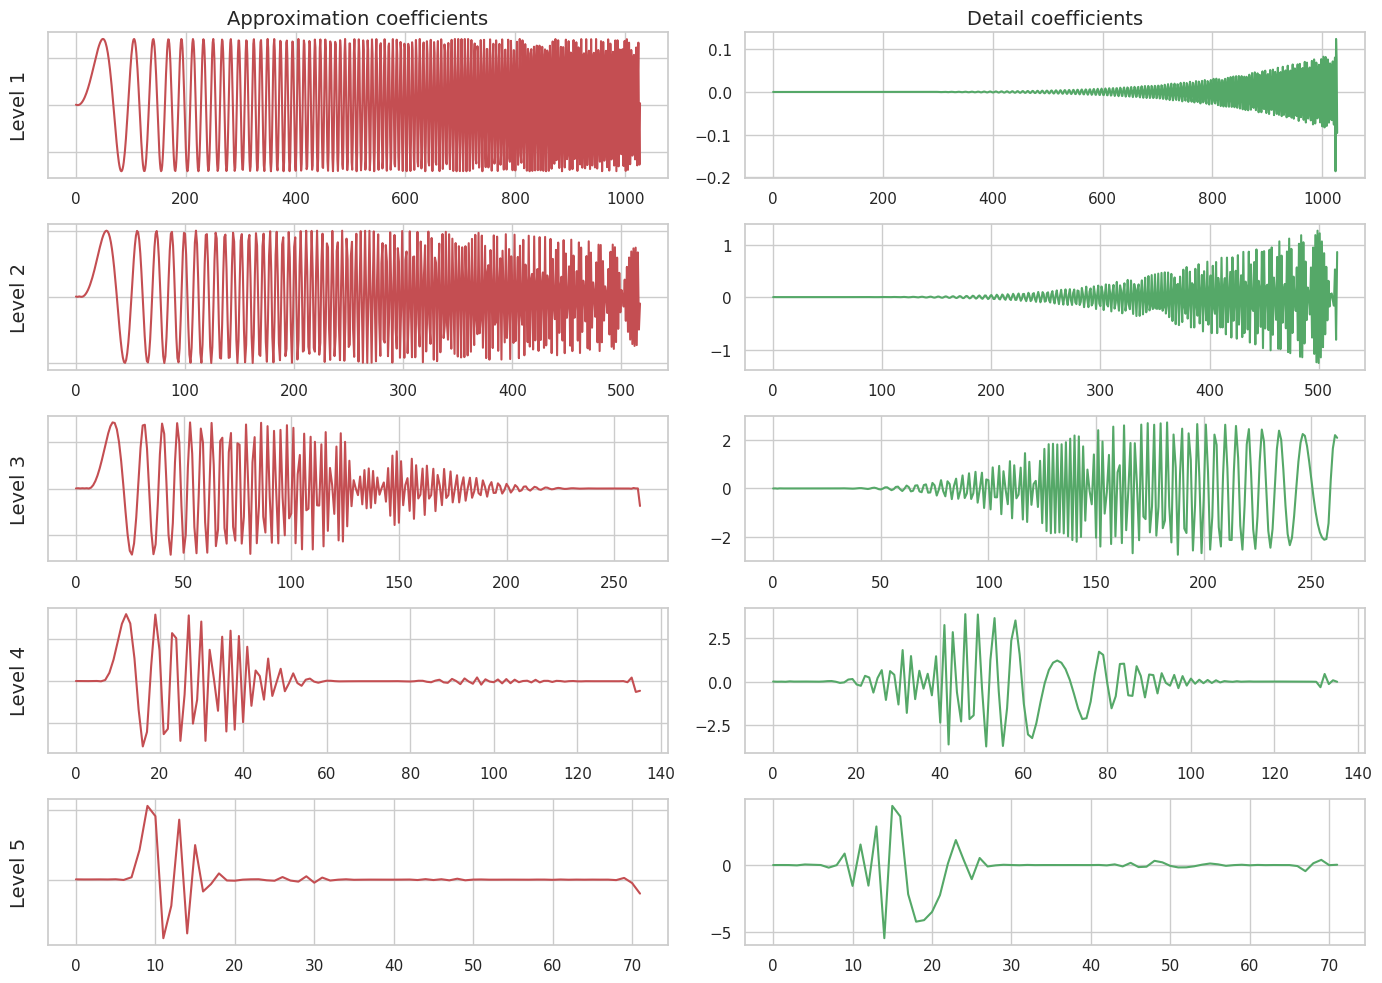

In [340]:
plot_dwt(chirp_signal)

In [341]:
from msr.signals.features import get_basic_signal_features

def get_dwt_freqs_and_coeffs(time, data, wavelet='db5', level=None):
    if level is None:
        level = pywt.dwt_max_level(len(data), wavelet)
    dt = time[1] - time[0]
    coeffs = pywt.wavedec(data, wavelet, level=level)
    scales = [2**(level - 1)] + [2**(level-i) for i in range(1, level+1)]
    freqs = np.array([pywt.scale2frequency(wavelet, scale) / dt for scale in scales])
    return freqs.round(4), coeffs

def extract_dwt_features(time, data, wavelet="db5", level=None):
    freqs, coeffs = get_dwt_freqs_and_coeffs(time, data, wavelet, level)
    level = len(freqs) - 1
    names = [f"approximation_{level}_freq_{freqs[0]}"] + [f"detail_{level - i}_freq_{freqs[i + 1]}" for i in range(level)]
    features = {}
    for name, coeff in zip(names, coeffs):
        features[name] = get_basic_signal_features(coeff)
    return features

In [342]:
freqs, coeffs = get_dwt_freqs_and_coeffs(x, chirp_signal)

In [343]:
freqs

array([  21.3229,   21.3229,   42.6458,   85.2917,  170.5833,  341.1667,
        682.3333, 1364.6667])

In [238]:
extract_dwt_features(x, chirp_signal)

{'approximation_9_freq_5.3327': {'entropy': 3.1780538303479453,
  'zero_cross_number': 13,
  'zero_pos_cross_std': 0.4898979485566356,
  'zero_neg_cross_std': 0.4714045207910317,
  'mean_cross_number': 5,
  'mean_pos_cross_std': 0.0,
  'mean_neg_cross_std': 0.5,
  'percentile_5': -0.00834770047329028,
  'percentile_25': -7.072496083410763e-06,
  'percentile_75': 0.09137082591161991,
  'percentile_95': 0.5503083086046454,
  'median': 8.730344353565966e-06,
  'mean': 0.14335381095844577,
  'std': 0.3726106111331886,
  'var': 0.1388386675290483,
  'root_mean_square': 0.15979049443369622},
 'detail_9_freq_5.3327': {'entropy': 3.1780538303479453,
  'zero_cross_number': 14,
  'zero_pos_cross_std': 1.707825127659933,
  'zero_neg_cross_std': 2.140872096444188,
  'mean_cross_number': 4,
  'mean_pos_cross_std': 0.0,
  'mean_neg_cross_std': 0.0,
  'percentile_5': -0.5359900669193084,
  'percentile_25': -0.006825794117960748,
  'percentile_75': 0.006055383835270083,
  'percentile_95': 0.0585417427

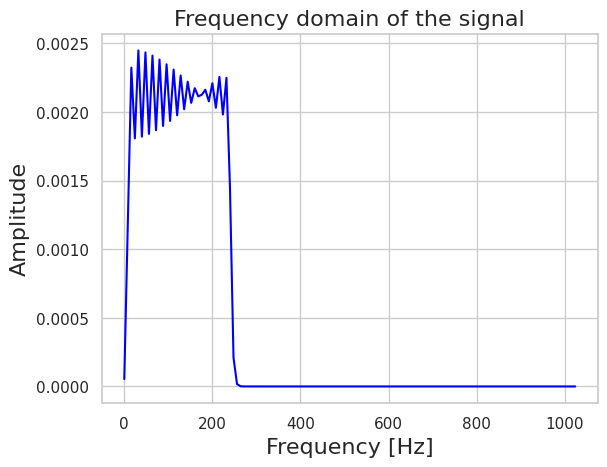

In [345]:
from scipy.signal import welch

def get_psd_values(y_values, f_s):
    f_values, psd_values = welch(y_values, fs=f_s)
    return f_values, psd_values

f_values, fft_values = get_psd_values(chirp_signal, 2048)

plt.plot(f_values, fft_values, linestyle='-', color='blue')
plt.xlabel('Frequency [Hz]', fontsize=16)
plt.ylabel('Amplitude', fontsize=16)
plt.title("Frequency domain of the signal", fontsize=16)
plt.show()

In [242]:
wp = pywt.WaveletPacket(data=chirp_signal, wavelet='db5', mode='symmetric')

In [254]:
wp.decompose()[0].

In [247]:
node = wp.get_level(3, order="freq")[0]

In [248]:
node.

In [327]:
def get_cwt_img(time, data, freq_dim_scale=256, wavelet='morl', plot=True):
    """Continuous wavelet transform"""
    dt = time[1] - time[0]
    freq_centre = pywt.central_frequency(wavelet)
    cparam = 2 * freq_centre * freq_dim_scale
    scales = cparam / np.arange(1, freq_dim_scale + 1, 1)
    cwt_matrix, freqs = pywt.cwt(data, scales, wavelet, dt)
    cwt_matrix = abs(cwt_matrix)
    if plot:
        fig, ax = plt.subplots(figsize=(14, 8))
        im = ax.contourf(x, freqs, cwt_matrix, cmap=plt.cm.seismic)
        fig.colorbar(im)
    return freqs, cwt_matrix

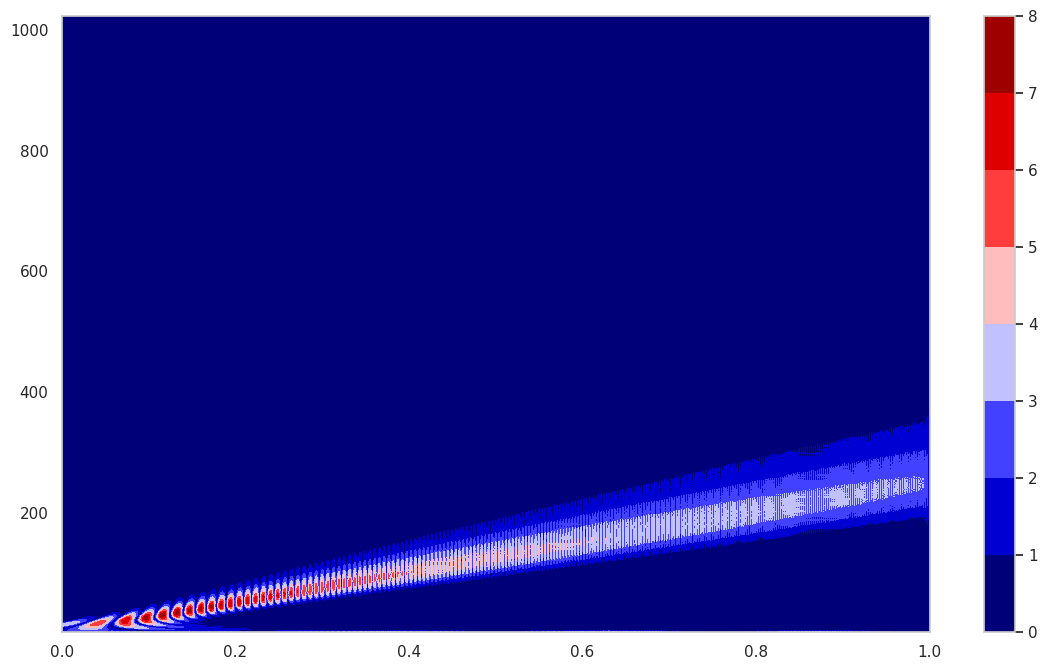

In [346]:
freqs, cwt_matrix = get_cwt_img(x, chirp_signal, freq_dim_scale=512)